## National Weather Service (NWS) API Plotting
This notebook is intented to test the National Weather Service (NWS) Web Service API to learn how it functions. It pulls temperature data from various Observation Stations and plots the result on a geographical map.

### Terminology:
wfo = Weather Forecast Office

### Useful Documents:
- weather.gov Github: https://weather-gov.github.io/api/general-faqs
- weather.gov API documentation: https://www.weather.gov/documentation/services-web-api#/

### Useful API calls
Base url
<br>
https://api.weather.gov/

Returns a list of nearby observation stations for a given GPS coordinate {latitude, longitude}.
<br>
/points/{point}/stations
<br>
example: https://api.weather.gov/points/41.8831,-87.6218/stations

Returns metadata about a given GPS coordinate
<br>
/points/{point}
<br>
example: https://api.weather.gov/points/41.8831,-87.6218

Returns the latest observation for a station
<br>
/stations/{stationId}/observations/latest
<br>
example: https://api.weather.gov/stations/KMDW/observations/latest

Returns a list of observations for a given station
<br>
/stations/{stationId}/observations

In [1]:
import requests                  # used to get data from web service API's
import json                      # used to process responses from API
import geopandas as gpd          # used to organize geographical data
import pandas as pd              # used to organize data
import matplotlib.pyplot as plt  # used to plot
import descartes                 # used to make maps (geopandas plot dependency)
import datetime as dt            # used to create timestamps for plots

In [2]:
# Test hard-coded request to weather

# request weather info via GPS coordinates (points)
# Retrieve the metadata for your location from https://api.weather.gov/points/{lat},{lon}

# Coordinates for Millenium Park in Chicago, Illinois
# 41.8831, -87.6218
# NWS API only allows 4 decimal precision on GPS coordinates
# https://api.weather.gov/points/41.8831,-87.6218
# https://api.weather.gov/points/41.8831,-87.6218/stations
lat = str(41.8831)
lon = str(-87.6218)


url_points='https://api.weather.gov/points/' + lat + ',' + lon + '/stations'
print(url_points)
r = requests.get(url_points)
d = json.loads(r.text)

# Pretty print json object
pretty = json.dumps(d, indent=2, separators=(',', ':'))
#print(pretty) # Do not print when uploading to GitHub because scroll bars are not used on GitHub.

https://api.weather.gov/points/41.8831,-87.6218/stations


In [3]:
# Extract weather station properties from json object

stationList = d['features']

# Extract closest weather station from json
closestStation = stationList[0]
stationProperties = closestStation['properties']
stationId = stationProperties['stationIdentifier']
print(f'Closest station to {lat}, {lon} is station: {stationId}') # Print closest station ID


# Extract all station ID's and GPS coordinates into pandas dataframe
df = pd.DataFrame() 
for station in stationList:
    
    # Parse Properties
    stationProperties = station['properties']
    stationId = stationProperties['stationIdentifier']
    stationName = stationProperties['name']
    stationEndpoint = stationProperties['@id']
    
    # Parse Geometry
    coords = station['geometry']['coordinates']
    lat = coords[0]
    long = coords[1]
    
    df = df.append({'Station_Id':stationId,
                    'Name':stationName,
                    'Endpoint':stationEndpoint,
                    'Latitude':lat,
                   'Longitude':long}, ignore_index=True)

print(df.head())


Closest station to 41.8831, -87.6218 is station: KMDW
                                Endpoint  Latitude  Longitude  \
0  https://api.weather.gov/stations/KMDW -87.75528   41.78417   
1  https://api.weather.gov/stations/KORD -87.90444   41.97972   
2  https://api.weather.gov/stations/KGYY -87.40908   41.61212   
3  https://api.weather.gov/stations/KPWK -87.90472   42.12083   
4  https://api.weather.gov/stations/KIGQ -87.52822   41.54125   

                                            Name Station_Id  
0                Chicago, Chicago Midway Airport       KMDW  
1  Chicago, Chicago-O'Hare International Airport       KORD  
2                          Gary Regional Airport       KGYY  
3         Chicago / Wheeling, Pal-Waukee Airport       KPWK  
4                      Lansing Municipal Airport       KIGQ  


In [4]:
# Get current (latest) observations from nearby weatherstations
observationUrl = ''

for index, row in df.iterrows():
    currStationId = row['Station_Id']
    observationUrl = 'https://api.weather.gov/stations/' + currStationId + '/observations/latest'
    print(observationUrl)
    
    # request station observations
    r = requests.get(observationUrl)
    if (r.status_code != 200):
        print(f'Bad HTTP response. Status code: {r.status_code}')
        continue
    
    d = json.loads(r.text)
    
    temperature = d['properties']['temperature']['value']
    unitCode = d['properties']['temperature']['unitCode']
    # print(currStationId, temperature, unitCode)
    
    # For each row update the 'Temperature' value to it's latest value
    df.at[index, 'Latest_Observation_Endpoint'] = observationUrl
    df.at[index , 'Temperature'] = temperature
    df.at[index, 'Unit_Code'] = unitCode

print(df.head())

https://api.weather.gov/stations/KMDW/observations/latest
https://api.weather.gov/stations/KORD/observations/latest
https://api.weather.gov/stations/KGYY/observations/latest
https://api.weather.gov/stations/KPWK/observations/latest
https://api.weather.gov/stations/KIGQ/observations/latest
https://api.weather.gov/stations/KLOT/observations/latest
https://api.weather.gov/stations/KDPA/observations/latest
https://api.weather.gov/stations/KJOT/observations/latest
https://api.weather.gov/stations/KUGN/observations/latest
https://api.weather.gov/stations/KVPZ/observations/latest
https://api.weather.gov/stations/KARR/observations/latest
https://api.weather.gov/stations/KC09/observations/latest
https://api.weather.gov/stations/KENW/observations/latest
https://api.weather.gov/stations/KDKB/observations/latest
https://api.weather.gov/stations/KIKK/observations/latest
https://api.weather.gov/stations/KRAC/observations/latest
https://api.weather.gov/stations/KBEH/observations/latest
https://api.we

In [5]:
# Convert dataframe to geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Latitude, df.Longitude))
print(gdf.head())

                                Endpoint  Latitude  Longitude  \
0  https://api.weather.gov/stations/KMDW -87.75528   41.78417   
1  https://api.weather.gov/stations/KORD -87.90444   41.97972   
2  https://api.weather.gov/stations/KGYY -87.40908   41.61212   
3  https://api.weather.gov/stations/KPWK -87.90472   42.12083   
4  https://api.weather.gov/stations/KIGQ -87.52822   41.54125   

                                            Name Station_Id  \
0                Chicago, Chicago Midway Airport       KMDW   
1  Chicago, Chicago-O'Hare International Airport       KORD   
2                          Gary Regional Airport       KGYY   
3         Chicago / Wheeling, Pal-Waukee Airport       KPWK   
4                      Lansing Municipal Airport       KIGQ   

                         Latest_Observation_Endpoint  Temperature  Unit_Code  \
0  https://api.weather.gov/stations/KMDW/observat...          0.6  unit:degC   
1  https://api.weather.gov/stations/KORD/observat...          0.6  uni

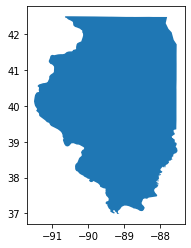

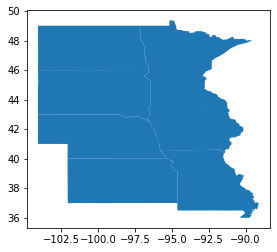

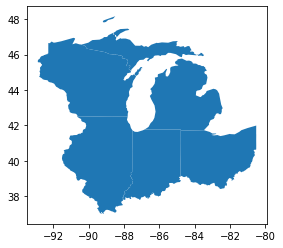

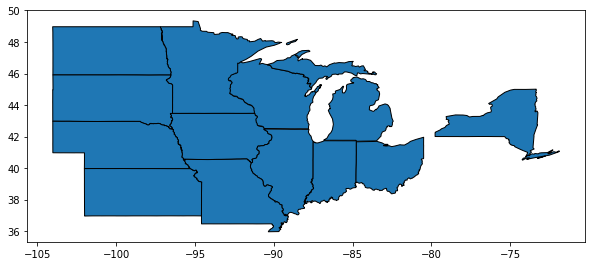

In [6]:
# Practice plotting shapes from shapefile (.shp)
# Use USA shapefile (.shp) downloaded from arcgis.com
# https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5
usa = gpd.read_file('states.shp')

usa[usa.STATE_ABBR == 'IL'].plot()
usa[usa.SUB_REGION == 'West North Central'].plot()
usa[usa.SUB_REGION == 'East North Central'].plot()

# Plot an arbitrary list of states
states = ['MN', 'WI', 'MI', 'IA', 'IL', 'IN', 'ND', 'SD', 'OH', 'NE', 'KS', 'MO', 'NY']
fix, ax = plt.subplots(figsize=(10,10))
for state in states:
    usa[usa.STATE_ABBR == f'{state}'].plot(ax=ax, edgecolor = 'black', linewidth=1)

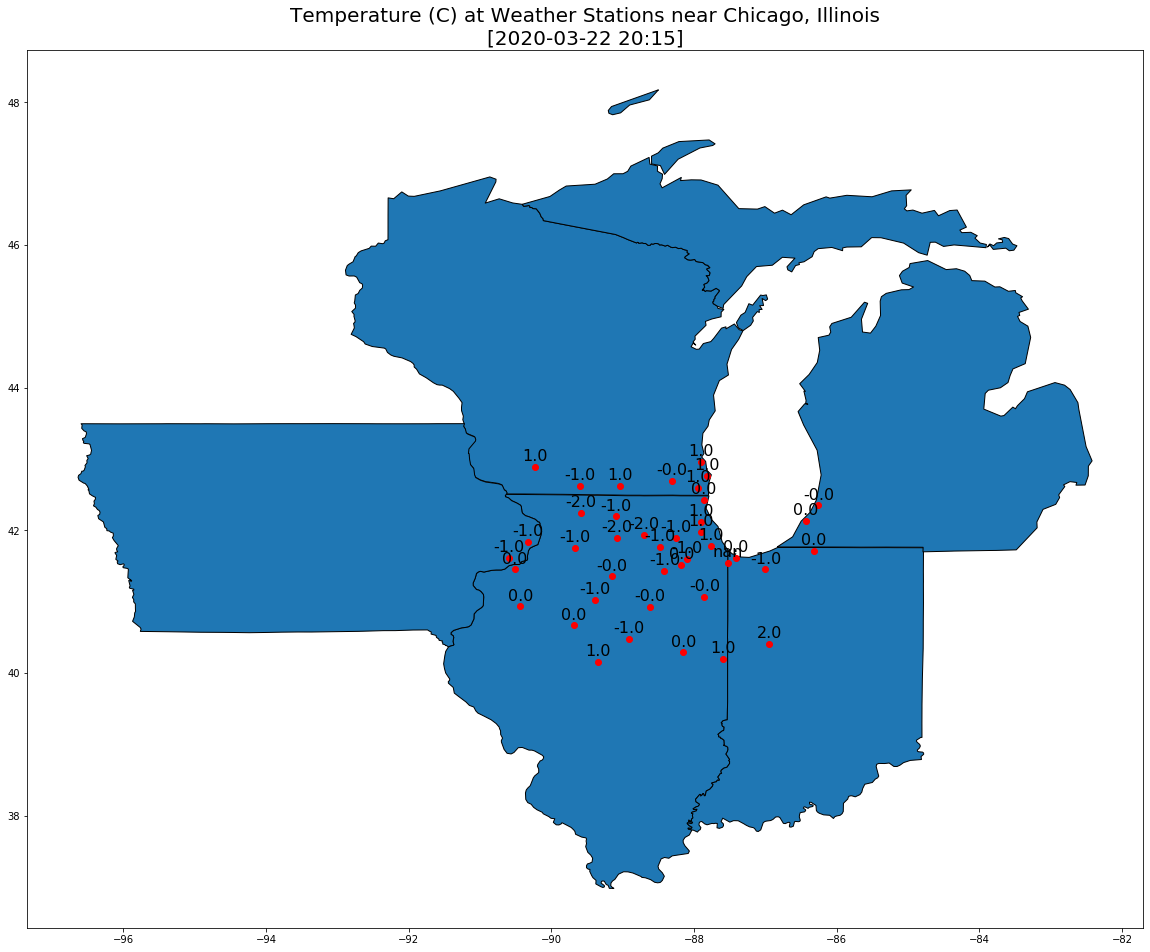

In [7]:
# Plot latest weather station temperature observations on map
states = ['IL', 'WI', 'IN', 'IA', 'MI']
fix, ax = plt.subplots(figsize=(20,20))
for state in states:
    usa[usa.STATE_ABBR == f'{state}'].plot(ax=ax, edgecolor = 'black', linewidth=1)

# Add weather station points to map
gdf.plot(ax=ax, color='red') 

currentTime = dt.datetime.now() # get current timestamp
timestamp = currentTime.strftime("[%Y-%m-%d %H:%M]")
ax.set_title('Temperature (C) at Weather Stations near Chicago, Illinois\n' + timestamp, fontsize=20)  # or size, alternatively

# Annotate temperature to each point
gdf.apply(lambda x: ax.annotate(s=round(x.Temperature,0),
                                xy=x.geometry.centroid.coords[0],
                                textcoords='offset points',
                                xytext=(0, 6), # offset amount from points
                                ha='center',
                                fontsize=16),axis=1);